In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from mude_tools import magicplotter
# use "%matplotlib widget" if on jupyter-lab, or "%matplotlib nbagg" if on jupyter-notebook
# %matplotlib nbagg
%matplotlib widget

## Introduction

So far, we have been using a non-parametric model with k-nearest neighbors, meaning we needed access to the whole training dataset for each prediction. We will now focus on parametric models, namely linear regression and generalized linear regression (GLR). Parametric models are defined by a finite set of parameters calibrated in a training step. All we need for a prediction then are the parameter values. There is no longer a need to carry the whole dataset with us; all the information is encoded in the model parameters. Once again, we will employ the simple sine function to demonstrate the concepts presented in this notebook.

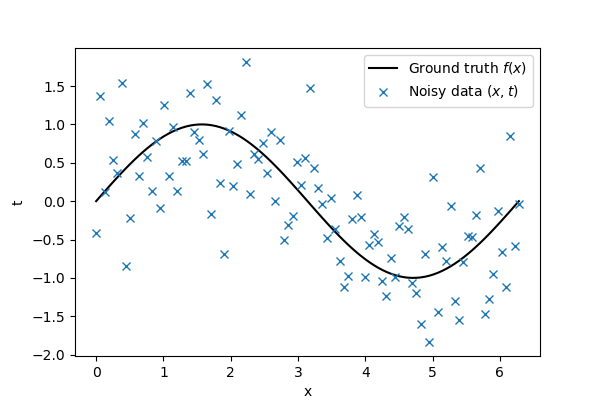

In [2]:
# The true function relating t to x
def f_truth(x, freq=1, **kwargs):
    
    # Return a sine with a frequency of f
    return np.sin(x * freq)

# The data generation function
def f_data(epsilon=0.7, N=100, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)
    
    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)
    
    # Generate N noisy observations (1 at each location)
    t = f_truth(x, **kwargs) + np.random.normal(0, epsilon, N)
    
    # Return both the locations and the observations
    return x, t

# Get the observed data
x, t = f_data()

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

plt.plot(x, f_truth(x), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

## Linear model

Even though the linear model is linear in its inputs, the key idea is that linear regression models and generalized linear regression models are linear in their parameters, referred to the following as $\mathbf{w}$. The simplest approach is to model our target function $y(x)$ as a linear combination of the coordinates $x$:

$$ y(x,\mathbf{w}) = w_0 + w_1 x_1 $$

In the one dimensional case, this is equivalent to fitting a straight line through our datapoints. The parameter $w_0$, also referred to as bias (not to be confused with the model bias), determines the intercept, $w_1$ determines the slope. The introduction of a dummy input $x_0 = 1$ allows us to write the model in a more concise way:

$$ y(x,\mathbf{w}) = w_0 x_0 + w_1 x_1 = \mathbf{w}^T \mathbf{x}$$

<!-- Let us define a few things we need to generate the data and fit the model first, and then see how this model performs. Once again, we employ the sine wave from the previous notebooks and generate a dataset consisting of $N$ noisy observations of the true process.

$$ t = y( x, \mathbf w ) + \epsilon \hspace{0.6cm} \mathrm{with} \hspace{0.6cm} \epsilon \sim \mathcal{N} (0,\beta^{-1}) $$ -->

We will use the least squares error function from the previous notebook to fit our model, but will first show how this choice is motivated by a Maximum likelihood approach.

## Maximum Likelihood Estimation

Oftentimes, it is justified to assume the target $t$ is given by a deterministic function $y(x, \mathbf{w})$ with additive Gaussian noise so that

$$ t = y( x, \mathbf w ) + \epsilon \hspace{0.6cm} \mathrm{with} \hspace{0.6cm} \epsilon \sim \mathcal{N} (0,\beta^{-1}), $$

with precision $\beta$. The precision is also referred to as inverse variance and reflects the inherent noise in our data. Given a new input $x$, the probability that our model predicts a given value $t$ is

$$ p (t | x, \mathbf{w}, \beta) = \mathcal{N} (t | y (x, \mathbf{w}), \beta^{-1}). $$

Consider a dataset $\mathcal{D}$ consisting of inputs $\mathbf{X} = \{ \mathbf{x}_1, \dots, \mathbf{x}_n \}$ and targets $\mathbf{t} = \{  t_1, \dots, t_n \}$. Assuming out datapoints were drawn independently, the probability that we draw exaclty this dataset from our model is

<!--$$ p ( \mathbf{t} | \mathbf{X}, \mathbf{w}, \beta) = \prod_{n = 1}^N \mathcal{N} ( t_n | \mathbf{w}^T \mathbf{x}_n, \beta^{-1}), $$-->
$$p( \mathcal{D}|\mathbf{w}) =  \prod_{n = 1}^N \mathcal{N} (t_i | y (x_i, \mathbf{w}), \beta^{-1}), $$

also referred to as the likelihood function. Taking its logarithm gives

$$ \mathrm{ln} \, p( \mathcal{D}|\mathbf{w}) = \sum_{n = 1}^{N} \mathrm{ln} \, \mathcal{N} ( t_n | \mathbf{w}^T \mathbf{x}_n, \beta^{-1}) = \frac{N}{2} \mathrm{ln} \beta - \frac{N}{2}\mathrm{ln}(2 \pi) - \beta \, \underbrace{\frac{1}{2} \sum_{n = 1}^{N} ( t_n - \mathbf{w}^T \mathbf{x}_n)^2}_{E_\mathcal{D}}$$

where we can identify our square-error loss function in the last term. Note that the first two terms are constant for a given dataset and have no influence on the parameter setting $\bar{\mathbf{w}}$ that maximizes the likelihood. Those optimal parameters values $\bar{\mathbf{w}}$ can be obtained by setting the gradient of our loss function w.r.t. $\mathbf{w}$ to zero and solving for $\mathbf{w}$.

$$ \nabla_{\mathbf{w}} E_{\mathcal{D}} = \frac{1}{N} \sum_{n=1}^N \big(t_n - \mathbf{w}^T \mathbf{x}_n \big) \mathbf{x}_n  \stackrel{!}{=} 0 $$

It is convenient to concatenate all inputs to a *design matrix* $\mathbf{X} = [\mathbf{x}_1^T, ..., \mathbf{x}_N^T]^T$. Solving for $\mathbf{w}$ gives

$$ \bar{\mathbf{w}} = \big( \mathbf{X}^T \mathbf{X} \big)^{-1} \mathbf{X}^T \mathbf{t} $$

Let us now define a few tools we need to state, solve, and visualize our problem.

In [3]:
# Function for the basis functions
def LinearBasis(x, **kwargs):
    """
    Represents a 1D linear basis.
    """
    num_basis = 2  # The number of basis functions is 2 due to the dummy input
    x = x.reshape(-1,1)
    return np.hstack((np.ones_like(x),x))

In [4]:
# Let's test our implementation
print("Design matrix X given by:\n\n", LinearBasis(np.arange(0,5)))

Design matrix X given by:

 [[1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]]


In [5]:
# Now we need a generic function that solves the least squares problem for us
def solve_least_squares(X, t, phi):
    """
    Arguments:
    X   -  The observed inputs (1D array)
    t   -  The observed targets (1D array)
    phi -  The basis functions.
    """
    
    Phi = phi(X)
    t = t.reshape(-1,1)
    
    return np.linalg.solve(Phi.T @ Phi, Phi.T @ t)

We are **not** inverting $\boldsymbol{X}^T \boldsymbol{X}$, which is extremely expensive for large amounts of data. A more efficient way to obtain $\mathbf{w}$ is to solve $\boldsymbol{X}^T \boldsymbol{X} \mathbf{w} = \boldsymbol{X}^T \mathbf{t}$. It is important to note that this approach only works for a well-defined system of equations, i.e.
$\boldsymbol{X}^T \boldsymbol{X}$ must be of full rank.

In [6]:
# Define the prediction locations
# (note that these are different from the locations where we observed our data)
x_pred = np.linspace(-1, 2*np.pi+1, 1000)

# Define a function that makes a GLR prediction at the given locations, based on the given (x,t) data
def GLR(x, t, x_pred, basis, **kwargs):
    
    # Get the variable matrix using the basis function phi
    Phi = basis(x, **kwargs)
    
    # Get the coefficient vector
    w = np.linalg.solve(Phi.T @ Phi, Phi.T @ t)
    
    # Make a prediction in the prediction locations
    Phi_pred = basis(x_pred, **kwargs)
    y_pred = Phi_pred @ w
    
    # Return the predicted values
    return y_pred

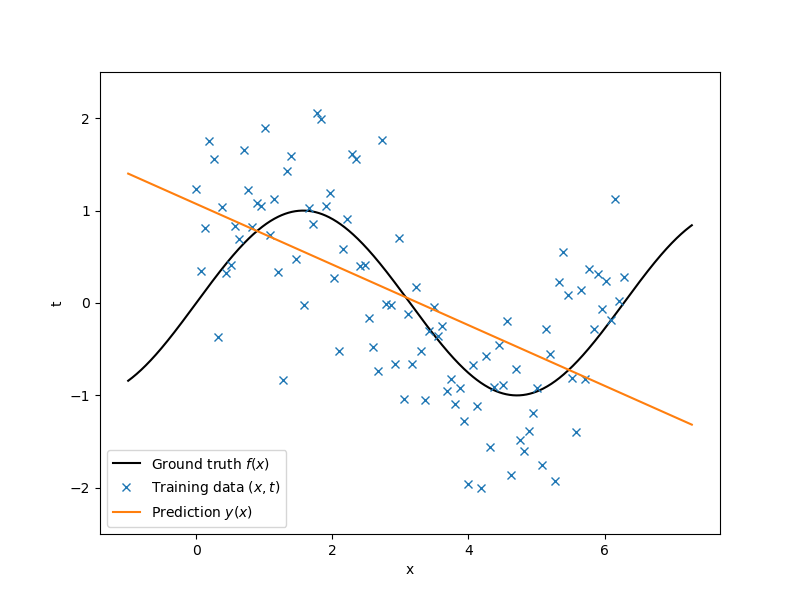

In [7]:
# Let's run our model with linear basis funcitons and plot the results
plot = magicplotter(f_data, f_truth, GLR, x_pred, basis=LinearBasis, pred_label='Prediction $y(x)$')
plot.show()

It is clear from the plot that a linear model with linear features lacks the flexibility to fit the data well. A bias-variance decomposition would show that the model has little variance but shows a strong bias. We now consider nonlinear functions of the input $x$ as features/regressors to increase the flexibility of our linear model. A common approach is to use a set of polynomial basis functions,

$$ \phi_j(x) = x^j, $$

but numerous other choices are possible. The full formulation for a model with $M$ polynomial basis functions is thus

$$ y(x,\mathbf{w}) = w_0 x^0 + w_1 x^1 + w_2 x^2 + ... + w_M x^M, $$

which shows how the model is still linear w.r.t. $\mathbf{w}$.

When defining a model, we only need to ensure that we have more data points than basis functions for the problem to be well defined and that the basis functions are linearly independent. The design matrix for this more general case writes

$$ \Phi_{ij} = \phi_j(x_i). $$

Let's implement a `PolynomialBasis` function.

In [8]:
# Here is a function for the polynomial basis functions:
def PolynomialBasis(x, degree, **kwargs):  #**kwargs):
    """
    A function that computes polynomial basis functions.
    
    Arguments:
    x       -  The datapoints
    degree  -  The degree of the polynomial
    """
    return np.array([x ** i for i in range(degree + 1)]).transpose()

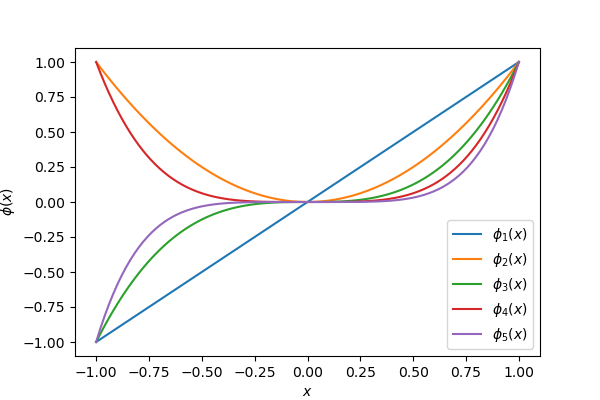

In [9]:
# Let's test our implementation and visualize the polynomial basis functions
degree = 5

x_test = np.linspace(-1,1,100)
Phi_p_test = PolynomialBasis(x_test, degree=degree)[:,1::]

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

for i, row in enumerate(Phi_p_test.transpose()):
    plt.plot(x_test, row, label=r'$\phi_{}(x)$'.format(i + 1))
    
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi(x)$')
plt.legend()
plt.show()

We obtain the generalized linear model (GLM) by replacing the coordinate vector $x$ with the  feature vector $\boldsymbol{\phi}(x)$

$$ y(x,\mathbf{w}) = \sum_{j=0}^M w_j \phi_j(x) = \mathbf{w}^T \boldsymbol{\phi} (x).$$

The solution procedure remains the same, and we can solve for $\bar{\mathbf{w}}$ directly

$$ \bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t}.$$

Let's take a look a the GLR model with polynomial regressors.

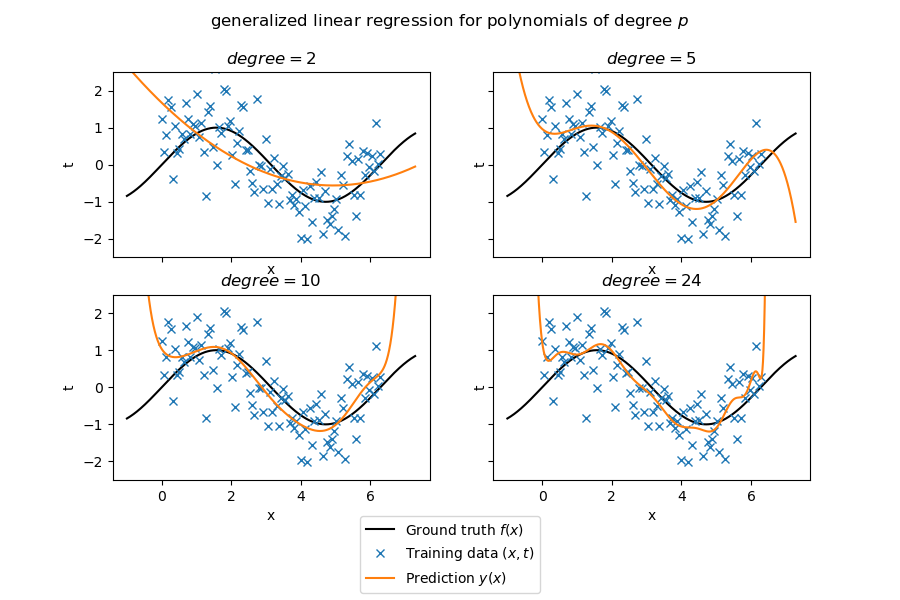

In [10]:
# Plot the resulting predictions
fig, ax = plt.subplots(2, 2, figsize=(9,6), sharex='all', sharey='all') 
plt.suptitle(r'generalized linear regression for polynomials of degree $p$')

# Plot for degree=2
magicplotter(f_data, f_truth, GLR, x_pred, basis=PolynomialBasis, degree=2, ax=ax[0][0], hide_legend=True, pred_label=r'Prediction $y(x)$', title=r'$degree={degree}$')

# Plot for degree=5
magicplotter(f_data, f_truth, GLR, x_pred, basis=PolynomialBasis, degree=5, ax=ax[0][1], hide_legend=True, title=r'$degree={degree}$')

# Plot for degree=10
magicplotter(f_data, f_truth, GLR, x_pred, basis=PolynomialBasis, degree=10, ax=ax[1][0], hide_legend=True, title=r'$degree={degree}$')

# Plot for degree=24
magicplotter(f_data, f_truth, GLR, x_pred, basis=PolynomialBasis, degree=24, ax=ax[1][1], hide_legend=True, title=r'$degree={degree}$')

# Add a general legend at the bottom of the plot
plt.subplots_adjust(bottom=0.2)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')

plt.show()

That is looking much better already. However, the quality of the fit varies significantly with the degree of the polynomial basis. There seems to be an ideal model complexity for this specific problem. Try out the interactive tool below to get an idea of the interplay of the following variables:
- $k$, the degree of the polynomial basis
- $N$, the size of the training data set
- $freq$, the frequency of the underlying truth
- $\varepsilon$, the level of noise associated with the data
- The seed can be updated to generate new random data sets
- The truth can be hidden to simulate a situation that is closer to a practical setting

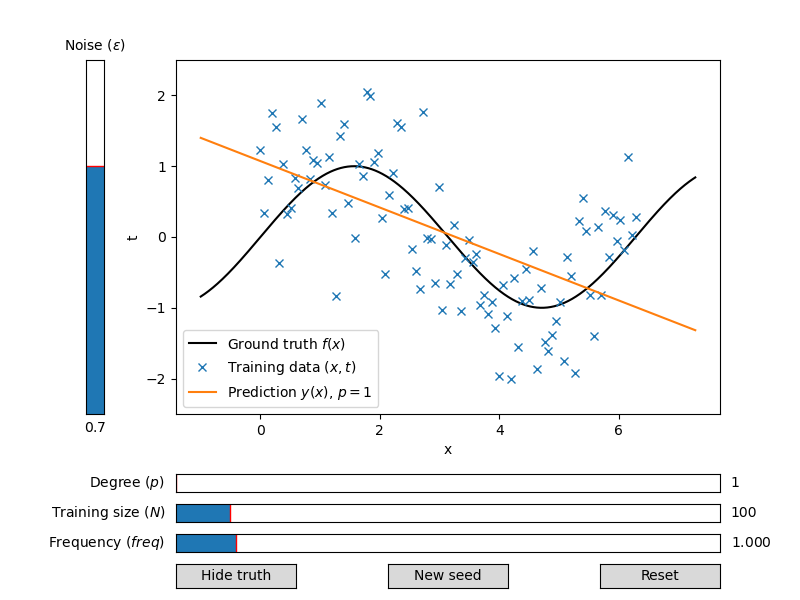

In [11]:
plot1 = magicplotter(f_data, f_truth, GLR, x_pred, basis=PolynomialBasis, pred_label=r'Prediction $y(x)$, $p={degree}$')
plot1.add_sliders('epsilon', 'degree', 'N', 'freq')
plot1.add_buttons('truth', 'seed', 'reset')
plot1.show()

A few questions that might have crossed your minds when playing with the tool:

- With a small amount of data ($N \leq 11$), what happens if we have as many data points as parameters? $(p + 1 = N)$
- With a small amount of data ($N \leq 11$), what happens if we have more model parameters than data? $(p + 1 > N)$
- Why do you think this changes for larger datasets?
- We only have access to data in the interval $[0,2\pi]$. How well does our model extrapolate beyond the data range?

## Other choices of basis functions

As mentioned previously, the polynomial basis is just one choice among many to define our model. Depending on the problem setting, a different set of basis functions might lead to better results. Another popular choice is the radial basis functions, given by

$$ \phi_j(x) = \exp\left\{-\frac{(x-\mu_j)^2}{2\ell^2}\right\} \quad \mathrm{for} \quad j=1,\dots,M $$

where $\phi_j$ is centered around $\mu_j$, $l$ determines the width, and $M$ refers to the number of basis functions. Let's implement a `RadialBasisFunctions` function:

In [12]:
# Here is a function for the RadialBasisFunctions:
def RadialBasisFunctions(x, M_radial, l_radial, **kwargs):
    """
    A function that computes radial basis functions.
    
    Arguments:
    X        -  The centers of the radial basis functions.
    M_radial -  The number of basis functions
    l_radial -  The width of each basis function
    """
    
    mu = np.linspace(0, 2*np.pi, M_radial)
    num_basis = mu.shape[0]

    Phi = np.ndarray((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:,i] = np.exp(-.5 * (x - mu[i]) ** 2 / l_radial ** 2)
    return Phi

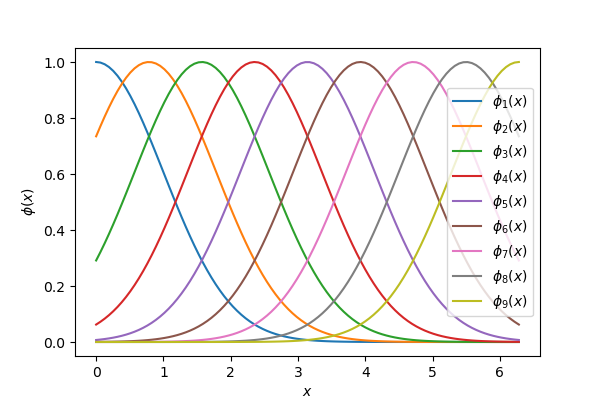

In [13]:
# Let's test our implementation
l_radial = 1.
M_radial = 9

x_test = np.linspace(0,2*np.pi,100)

Phi_radial_test = RadialBasisFunctions(x_test, M_radial=M_radial, l_radial=l_radial)

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

for i, row in enumerate(Phi_radial_test.transpose()):
    plt.plot(x_test, row, label=r'$\phi_{}(x)$'.format(i + 1))
    
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi(x)$')
plt.legend()
plt.show()

One of the radial basis' attributes is the locality of its individual functions. This means data in one part of the domain will not impact predictions in other parts of the domain. Periodicity can be achieved with a Fourier basis. Wavelets are popular in signal processing since they are localized in both frequency and space. It is up to the user to determine which basis function properties are desired for a given problem. Try to implement some of these basis functions yourself and assess how well they compare with the pre-implemented ones.

Let's see how well the GLM with radial basis functions performs on the sine wave problem.

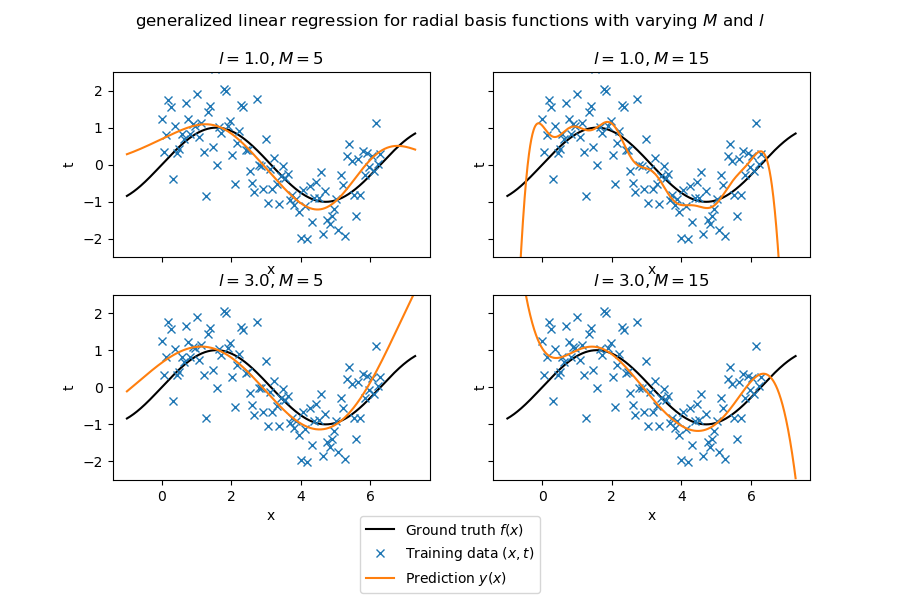

In [14]:
# Plot the resulting predictions
fig, ax = plt.subplots(2, 2, figsize=(9,6), sharex='all', sharey='all') 
plt.suptitle(r'generalized linear regression for radial basis functions with varying $M$ and $l$')

# Plot for l=1.0, M=5
magicplotter(f_data, f_truth, GLR, x_pred, basis=RadialBasisFunctions, M_radial=5, l_radial=1.0, ax=ax[0][0], hide_legend=True, pred_label=r'Prediction $y(x)$', title=r'$l = {l_radial}, M = {M_radial}$')

# Plot for l=1.0, M=15
magicplotter(f_data, f_truth, GLR, x_pred, basis=RadialBasisFunctions, M_radial=15, l_radial=1.0, ax=ax[0][1], hide_legend=True, title=r'$l = {l_radial}, M = {M_radial}$')

# Plot for l=3.0, M=5
magicplotter(f_data, f_truth, GLR, x_pred, basis=RadialBasisFunctions, M_radial=5, l_radial=3.0, ax=ax[1][0], hide_legend=True, title=r'$l = {l_radial}, M = {M_radial}$')

# Plot for l=3.0, M=15
magicplotter(f_data, f_truth, GLR, x_pred, basis=RadialBasisFunctions, M_radial=15, l_radial=3.0, ax=ax[1][1], hide_legend=True, title=r'$l = {l_radial}, M = {M_radial}$')

# Add a general legend at the bottom of the plot
plt.subplots_adjust(bottom=0.2)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')

plt.show()

The figure above shows four different combinations of the hyperparameters (number of basis functions and length scale). The quality of the fit depends strongly on the parameter setting, but a visual inspection indicates our model can replicate the general trend.

## Final remarks

This notebook introduced the generalized linear models to increase our model's flexibility. We have seen that increased flexibility is not always good if we perform a simple least-squares analysis. We know from the previous notebook that we can introduce a validation set to prevent our model from overfitting; however, removing features is not always as trivial as for the polynomial basis. The following lecture and its accompanying notebook will introduce you to ridge regression, a concept for controlling the model complexity elegantly.